In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mizani.formatters import percent_format
from plotnine import *
import regex as re
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings

from patsy import dmatrices
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore")

In [2]:
raw_data = pd.read_csv("listings.csv", index_col = 0)

In [3]:
# checking out the data

raw_data.shape

(29357, 74)

In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29357 entries, 2737 to 1046345431682207827
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   listing_url                                   29357 non-null  object 
 1   scrape_id                                     29357 non-null  int64  
 2   last_scraped                                  29357 non-null  object 
 3   source                                        29357 non-null  object 
 4   name                                          29357 non-null  object 
 5   description                                   0 non-null      float64
 6   neighborhood_overview                         17561 non-null  object 
 7   picture_url                                   29357 non-null  object 
 8   host_id                                       29357 non-null  int64  
 9   host_url                                      293

Many columns with missing values, and unusable data. This needs to be cleared up.

In [5]:
raw_data.head()

,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,
2737,https://www.airbnb.com/rooms/2737,20231215032808,2023-12-15,city scrape,Place to stay in Rome · ★4.80 · 1 bedroom · 1 ...,NaN,It used to be an industrial area until late 80...,https://a0.muscache.com/pictures/41225252/e955...,3047,https://www.airbnb.com/users/show/3047,...,5.00,4.40,4.40,NaN,f,6,0,6,0,0.05
3079,https://www.airbnb.com/rooms/3079,20231215032808,2023-12-16,previous scrape,Rental unit in Rome · ★4.53 · 1 bedroom · 1 be...,NaN,Monti neighborhood is one of the best areas in...,https://a0.muscache.com/pictures/miso/Hosting-...,3504,https://www.airbnb.com/users/show/3504,...,4.86,4.81,4.43,NaN,f,6,6,0,0,0.13
11834,https://www.airbnb.com/rooms/11834,20231215032808,2023-12-15,city scrape,Rental unit in Rome · ★4.83 · 1 bedroom · 1 be...,NaN,"""Monti"" with its narrow cobblestone alleys, cr...",https://a0.muscache.com/pictures/miso/Hosting-...,44552,https://www.airbnb.com/users/show/44552,...,4.95,4.99,4.77,NaN,f,1,1,0,0,1.43
75474,https://www.airbnb.com/rooms/75474,20231215032808,2023-12-15,city scrape,Villa in Rome · 9 bedrooms · 10 beds · 6.5 baths,NaN,"Bel Poggio is a green hill, with beautiful tre...",https://a0.muscache.com/pictures/miso/Hosting-...,400717,https://www.airbnb.com/users/show/400717,...,5.00,5.00,5.00,NaN,t,1,1,0,0,0.31
12398,https://www.airbnb.com/rooms/12398,20231215032808,2023-12-15,city scrape,Rental unit in Rome · ★4.92 · 2 bedrooms · 3 b...,NaN,You are at 15 minutes walking distance from hi...,https://a0.muscache.com/pictures/miso/Hosting-...,11756,https://www.airbnb.com/users/show/11756,...,5.00,4.87,4.85,NaN,f,1,1,0,0,0.41


In [6]:
raw_data.describe()

,scrape_id,description,host_id,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,2.935700e+04,0.0,2.935700e+04,29348.000000,29348.000000,0.0,29357.000000,29357.000000,29357.000000,0.0,...,25110.000000,25108.000000,25109.000000,25106.000000,25107.000000,29357.000000,29357.000000,29357.000000,29357.000000,25086.000000
mean,2.023122e+13,NaN,1.701936e+08,15.669518,22.849496,NaN,41.891868,12.480778,3.704738,NaN,...,4.737202,4.822568,4.828908,4.725428,4.640687,9.096468,7.466499,1.463229,0.028920,1.721920
std,9.441567e+00,NaN,1.804467e+08,74.349640,141.132811,NaN,0.035648,0.048908,2.047440,NaN,...,0.374172,0.318679,0.330444,0.349063,0.400160,29.698329,29.436500,3.279938,0.423475,1.671394
min,2.023122e+13,NaN,1.944000e+03,1.000000,1.000000,NaN,41.656792,12.238500,1.000000,NaN,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,2.023122e+13,NaN,2.042828e+07,1.000000,1.000000,NaN,41.885448,12.461160,2.000000,NaN,...,4.660000,4.790000,4.800000,4.610000,4.540000,1.000000,1.000000,0.000000,0.000000,0.400000
50%,2.023122e+13,NaN,8.683540e+07,3.000000,3.000000,NaN,41.896580,12.477890,4.000000,NaN,...,4.840000,4.910000,4.930000,4.830000,4.730000,2.000000,1.000000,0.000000,0.000000,1.210000
75%,2.023122e+13,NaN,2.975611e+08,7.000000,8.000000,NaN,41.906480,12.504410,4.000000,NaN,...,4.970000,5.000000,5.000000,4.960000,4.860000,6.000000,3.000000,2.000000,0.000000,2.600000
max,2.023122e+13,NaN,5.508256e+08,2461.000000,5521.000000,NaN,42.121310,12.835699,16.000000,NaN,...,5.000000,5.000000,5.000000,5.000000,5.000000,265.000000,264.000000,39.000000,12.000000,38.560000


Columns to be dropped due to irrelenvance or many missing values
- host_id
- host_name
- neighborhood_overview
- listings_url
- scrape_id
- last_scraped
- source
- name
- description
- picture_url
- host_url
- host_about
- host_thumbnail_url
- host_picture_url
- neighbourhood
- neighbourhood_group_cleansed
- bathrooms
- bedrooms
- amenities
- calendar_updated
- calendar_last_scraped
- licence
- first_review
- last_review
- latitude
- longitude


Columns to be transformed:
- host_response_rate (% mark)
- host_acceptance_rate (% mark)
- host_is_superhost (t/f instead of 1/0)
- host_has_profilepic (t/f instead of 1/0)
- host_identity_verified (t/f instead of 1/0)
- bathroom_text (get numerical value)
- price (remove $, convert to float)
- has_availability (t/f instead of 1/0)
- instant_bookable (t/f instead of 1/0)

In [7]:
to_drop = ["neighborhood_overview", "host_name", "host_id", "host_since", "listing_url", "scrape_id", "last_scraped", "source", "name", "description", 
           "latitude", "longitude", "picture_url", "host_url", "host_about", "host_thumbnail_url", "host_picture_url", "neighbourhood", "neighbourhood_group_cleansed",
           "bathrooms", "bedrooms", "amenities","calendar_updated", "first_review", "last_review", "calendar_last_scraped", "license"]

In [8]:
print(f'Dropping {len(to_drop)} columns.')

Dropping 27 columns.


In [9]:
data = raw_data.drop(to_drop, axis = 1).reset_index()

In [10]:
data = data.drop("id", axis = 1)

In [11]:
data

,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,"Rome, Italy",within a few hours,90%,3%,f,Testaccio,7.0,7.0,"['email', 'phone']",t,...,4.80,5.00,4.40,4.40,f,6,0,6,0,0.05
1,"Rome, Italy",within a few hours,100%,0%,f,Monti,6.0,11.0,"['email', 'phone']",t,...,4.71,4.86,4.81,4.43,f,6,6,0,0,0.13
2,"Rome, Italy",within a few hours,100%,100%,t,Monti,1.0,2.0,"['email', 'phone']",t,...,4.98,4.95,4.99,4.77,f,1,1,0,0,1.43
3,"London, United Kingdom",within an hour,100%,100%,f,NaN,1.0,3.0,"['email', 'phone']",t,...,5.00,5.00,5.00,5.00,t,1,1,0,0,0.31
4,"Rome, Italy",within a day,100%,92%,t,Flaminio,1.0,2.0,"['email', 'phone']",t,...,4.95,5.00,4.87,4.85,f,1,1,0,0,0.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29352,"Rome, Italy",within an hour,100%,100%,f,NaN,1.0,1.0,"['email', 'phone']",t,...,NaN,NaN,NaN,NaN,t,1,1,0,0,NaN
29353,"Rome, Italy",NaN,NaN,NaN,f,NaN,3.0,3.0,"['email', 'phone']",t,...,NaN,NaN,NaN,NaN,t,2,2,0,0,NaN
29354,"Rome, Italy",within a few hours,100%,46%,f,NaN,2.0,2.0,"['email', 'phone']",t,...,NaN,NaN,NaN,NaN,f,2,1,1,0,NaN
29355,"Rome, Italy",within an hour,93%,96%,f,NaN,65.0,121.0,"['email', 'phone']",t,...,NaN,NaN,NaN,NaN,t,45,45,0,0,NaN


In [12]:
# Drop % symbol in some columns

data.host_response_rate = data.host_response_rate.str.replace("%", "")
data.host_acceptance_rate = data.host_response_rate.str.replace("%", "")
data.host_response_rate = data.host_response_rate.str.replace("%", "")

In [13]:
data.head()

,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,"Rome, Italy",within a few hours,90,90,f,Testaccio,7.0,7.0,"['email', 'phone']",t,...,4.80,5.00,4.40,4.40,f,6,0,6,0,0.05
1,"Rome, Italy",within a few hours,100,100,f,Monti,6.0,11.0,"['email', 'phone']",t,...,4.71,4.86,4.81,4.43,f,6,6,0,0,0.13
2,"Rome, Italy",within a few hours,100,100,t,Monti,1.0,2.0,"['email', 'phone']",t,...,4.98,4.95,4.99,4.77,f,1,1,0,0,1.43
3,"London, United Kingdom",within an hour,100,100,f,NaN,1.0,3.0,"['email', 'phone']",t,...,5.00,5.00,5.00,5.00,t,1,1,0,0,0.31
4,"Rome, Italy",within a day,100,100,t,Flaminio,1.0,2.0,"['email', 'phone']",t,...,4.95,5.00,4.87,4.85,f,1,1,0,0,0.41


In [14]:
# convert t/f type columns to binary

t_f = ["host_is_superhost", "host_has_profile_pic", "host_identity_verified", "has_availability", "instant_bookable"]
for cols in t_f:
    data[cols] = data[cols] == "t"

In [15]:
# Drop NA price values and drop $ and , symbols

data.dropna(subset=['price'], inplace = True)

data.price = data.price.str.replace("$", "")
data.price = data.price.str.replace(",", "")
data.price

0          50.00
1         120.00
2         107.00
3        1973.00
4         102.00
          ...   
29352      60.00
29353      68.00
29354      50.00
29355     340.00
29356     138.00
Name: price, Length: 27381, dtype: object

In [16]:
# convert to float (not integer, in case there are non whole number prices)

data.price = data.price.astype(float)

In [17]:
# checking where there are NA values

to_filter=data.isna().sum()
to_filter[to_filter>0]

host_location                   6169
host_response_time              2735
host_response_rate              2735
host_acceptance_rate            2735
host_neighbourhood             14534
host_listings_count                9
host_total_listings_count          9
host_verifications                 9
bathrooms_text                    34
beds                             313
review_scores_rating            3510
review_scores_accuracy          3516
review_scores_cleanliness       3515
review_scores_checkin           3517
review_scores_communication     3516
review_scores_location          3517
review_scores_value             3517
reviews_per_month               3539
dtype: int64

### Handling missing values

For categorical variables (host_location, host_neighbourhood, host_response_time) NA values will be replaced with "Missing". It is worth noting here, that there will be many missing values for neighbourhood (around half of the dataset)
For beds, the missing data will be imputed with the number of accomodates. 
Given that there are more than 27,000 observations in the dataset, other observations with missing data will be dropped. This will still mean a dataset of around 23,000 observations.

In [18]:
data["host_location"] = data["host_location"].fillna("Missing")
data["host_neighbourhood"] = data["host_neighbourhood"].fillna("Missing")
data['beds']=data['beds'].fillna(data['accommodates'])

to_filter=data.isna().sum()
to_filter[to_filter>0]

host_response_time             2735
host_response_rate             2735
host_acceptance_rate           2735
host_listings_count               9
host_total_listings_count         9
host_verifications                9
bathrooms_text                   34
review_scores_rating           3510
review_scores_accuracy         3516
review_scores_cleanliness      3515
review_scores_checkin          3517
review_scores_communication    3516
review_scores_location         3517
review_scores_value            3517
reviews_per_month              3539
dtype: int64

In [19]:
data.dropna(subset=to_filter[to_filter>0].index, inplace = True)

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21964 entries, 0 to 29267
Data columns (total 47 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   host_location                                 21964 non-null  object 
 1   host_response_time                            21964 non-null  object 
 2   host_response_rate                            21964 non-null  object 
 3   host_acceptance_rate                          21964 non-null  object 
 4   host_is_superhost                             21964 non-null  bool   
 5   host_neighbourhood                            21964 non-null  object 
 6   host_listings_count                           21964 non-null  float64
 7   host_total_listings_count                     21964 non-null  float64
 8   host_verifications                            21964 non-null  object 
 9   host_has_profile_pic                          21964 non-null  bool

In [21]:
# checking bathrooms_text

data.bathrooms_text.value_counts()

bathrooms_text
1 bath               11945
2 baths               3537
1 private bath        3333
1 shared bath         1066
3 baths                622
1.5 baths              618
4 baths                168
2 shared baths         157
2.5 baths              130
1.5 shared baths        79
5 baths                 57
0 baths                 49
3.5 baths               39
6 baths                 35
0 shared baths          24
Half-bath               20
4.5 baths               15
2.5 shared baths        14
Shared half-bath        11
3 shared baths           8
7 baths                  8
8 baths                  5
5.5 baths                4
5 shared baths           3
6.5 baths                3
7.5 baths                3
9 baths                  2
6 shared baths           2
12.5 baths               2
Private half-bath        2
12 baths                 1
9.5 baths                1
10 shared baths          1
Name: count, dtype: int64

Most columns contain the numerical value as the first word. The text described values will be replaced manually.

In [22]:
data['bathrooms'] = data['bathrooms_text'].str.split(' ').str[0]

In [23]:
data.bathrooms.value_counts()

bathrooms
1            16344
2             3694
1.5            697
3              630
4              168
2.5            144
0               73
5               60
3.5             39
6               37
Half-bath       20
4.5             15
Shared          11
7                8
8                5
5.5              4
6.5              3
7.5              3
12.5             2
9                2
Private          2
12               1
9.5              1
10               1
Name: count, dtype: int64

In [24]:
data["bathrooms"].replace({"Half-bath": 0.5, "Shared" : 0.5, "Private": 0.5}, inplace = True)
data["bathrooms"] = data["bathrooms"].astype(float)
data.bathrooms.value_counts()

bathrooms
1.0     16344
2.0      3694
1.5       697
3.0       630
4.0       168
2.5       144
0.0        73
5.0        60
3.5        39
6.0        37
0.5        33
4.5        15
7.0         8
8.0         5
5.5         4
6.5         3
7.5         3
12.5        2
9.0         2
12.0        1
9.5         1
10.0        1
Name: count, dtype: int64

In [25]:
# dropping bathrooms_text column which is not relevant anymore

data = data.drop("bathrooms_text", axis = 1)

In [26]:
data.columns

Index(['host_location', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'property_type', 'room_type', 'accommodates',
       'beds', 'price', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21964 entries, 0 to 29267
Data columns (total 47 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   host_location                                 21964 non-null  object 
 1   host_response_time                            21964 non-null  object 
 2   host_response_rate                            21964 non-null  object 
 3   host_acceptance_rate                          21964 non-null  object 
 4   host_is_superhost                             21964 non-null  bool   
 5   host_neighbourhood                            21964 non-null  object 
 6   host_listings_count                           21964 non-null  float64
 7   host_total_listings_count                     21964 non-null  float64
 8   host_verifications                            21964 non-null  object 
 9   host_has_profile_pic                          21964 non-null  bool

In [28]:
# converting host_response_rate and host_acceptance_rate to numerical
data = data.astype({'host_response_rate':'float','host_acceptance_rate':'float'})

### Filtering out extreme/irrelevant values

In [29]:
data.accommodates.describe()

count    21964.000000
mean         3.783600
std          2.054248
min          1.000000
25%          2.000000
50%          4.000000
75%          4.000000
max         16.000000
Name: accommodates, dtype: float64

In [30]:
# The goal is to price apartments between 2-6 accomodates, therefore anything above 6 and below 2 accomodates, and non-apartment types are not relevant for the analysis. 

data=data.loc[data.accommodates < 7]
data=data.loc[data.accommodates > 1]

In [31]:
data.room_type.value_counts()

room_type
Entire home/apt    14684
Private room        4567
Hotel room           326
Shared room           22
Name: count, dtype: int64

In [32]:
data.property_type.unique()

array(['Entire rental unit', 'Entire vacation home',
       'Private room in condo', 'Private room in guesthouse',
       'Entire condo', 'Private room in bed and breakfast', 'Entire loft',
       'Private room in rental unit', 'Entire cottage',
       'Private room in home', 'Private room in loft',
       'Room in bed and breakfast', 'Room in boutique hotel',
       'Private room in casa particular', 'Entire villa', 'Entire home',
       'Room in serviced apartment', 'Private room in guest suite',
       'Private room in villa', 'Private room in vacation home',
       'Private room in farm stay', 'Entire cabin', 'Entire place',
       'Entire serviced apartment', 'Room in hotel', 'Entire townhouse',
       'Entire bed and breakfast', 'Entire guest suite',
       'Private room in serviced apartment', 'Entire bungalow',
       'Entire guesthouse', 'Private room', 'Private room in tower',
       'Room in aparthotel', 'Dome', 'Tiny home',
       'Private room in tiny home', 'Shared room i

In [33]:
# the types to be kept are "Entire home/apt", all others are to be dropped and the room_type column then can be dropped.

data = data[data['room_type'] == "Entire home/apt"]
data = data.drop("room_type", axis = 1)
data.shape

(14684, 46)

In [34]:
data.property_type.unique()

array(['Entire rental unit', 'Entire vacation home', 'Entire condo',
       'Entire loft', 'Entire cottage', 'Entire villa', 'Entire home',
       'Entire cabin', 'Entire place', 'Entire serviced apartment',
       'Entire townhouse', 'Entire bed and breakfast',
       'Entire guest suite', 'Entire bungalow', 'Entire guesthouse',
       'Dome', 'Tiny home', 'Entire chalet', 'Farm stay',
       'Casa particular', 'Entire home/apt', 'Room in aparthotel',
       'Camper/RV', 'Holiday park', 'Windmill', 'Minsu', 'Tower', 'Cave'],
      dtype=object)

There are some unusual property types, but they will be kept nonetheless.

In [35]:
# Checking out price values

data.price.describe(percentiles = [0.95, 0.99, 0.999])

count    14684.000000
mean       141.491011
std        212.638049
min          8.000000
50%        108.000000
95%        292.850000
99%        645.020000
99.9%     2970.631000
max      10777.000000
Name: price, dtype: float64

In [36]:
data.price.quantile(q=0.995)

800.0

There are some extremely high values in price. Less than 0.5% of the data is above 1000 EUR, which is extremely high and not relevant for our analysis. Therefore these will be dropped.

In [37]:
data=data.loc[data.price < 1000]
data.shape

(14630, 46)

In [38]:
# creating list of categorical and numerical (including boolean) variables - excluding our Y variable ("price")

cat_var = list(data.select_dtypes(['object']).columns)
cat_var

['host_location',
 'host_response_time',
 'host_neighbourhood',
 'host_verifications',
 'neighbourhood_cleansed',
 'property_type']

In [39]:
num_var = list(data.select_dtypes(['int64', 'bool', 'float64']).columns)
num_var.remove("price")
num_var

['host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_listings_count',
 'host_total_listings_count',
 'host_has_profile_pic',
 'host_identity_verified',
 'accommodates',
 'beds',
 'minimum_nights',
 'maximum_nights',
 'minimum_minimum_nights',
 'maximum_minimum_nights',
 'minimum_maximum_nights',
 'maximum_maximum_nights',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm',
 'has_availability',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'number_of_reviews',
 'number_of_reviews_ltm',
 'number_of_reviews_l30d',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'instant_bookable',
 'calculated_host_listings_count',
 'calculated_host_listings_count_entire_homes',
 'calculated_host_listings_count_private_rooms',
 'calculated_host_listings_count_shared_rooms',
 'reviews_per_month',
 'bathr

In [40]:
print(f'There are {len(cat_var)} categorical and {len(num_var)} numerical x variables in the data.')

There are 6 categorical and 39 numerical x variables in the data.


After looking at the list of x variables, they may be grouped in a few categories:
- variables related to the host
- variables related to the accomodation itself
- variables related to reviews

Intuitively one would expect that the accomodation variables define the price the most, then the reviews, then the host variables. 

In [41]:
host_vars = ['host_location', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_neighbourhood', 'host_verifications',
             'host_is_superhost', 'host_listings_count', 'host_total_listings_count', 'host_has_profile_pic', 'host_identity_verified', 
             'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 
             'calculated_host_listings_count_shared_rooms']

accom_vars = ['neighbourhood_cleansed', 'property_type', 'accommodates', 'beds', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 
              'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
              'availability_30', 'availability_60', 'availability_90', 'availability_365','instant_bookable', 'bathrooms']

review_vars = ['number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 
               'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value','reviews_per_month']
len(host_vars) + len(accom_vars) + len(review_vars)

45

## EDA

In [42]:
data.price.describe()

count    14630.000000
mean       132.570335
std         89.392500
min          8.000000
25%         82.000000
50%        108.000000
75%        151.000000
max        999.000000
Name: price, dtype: float64

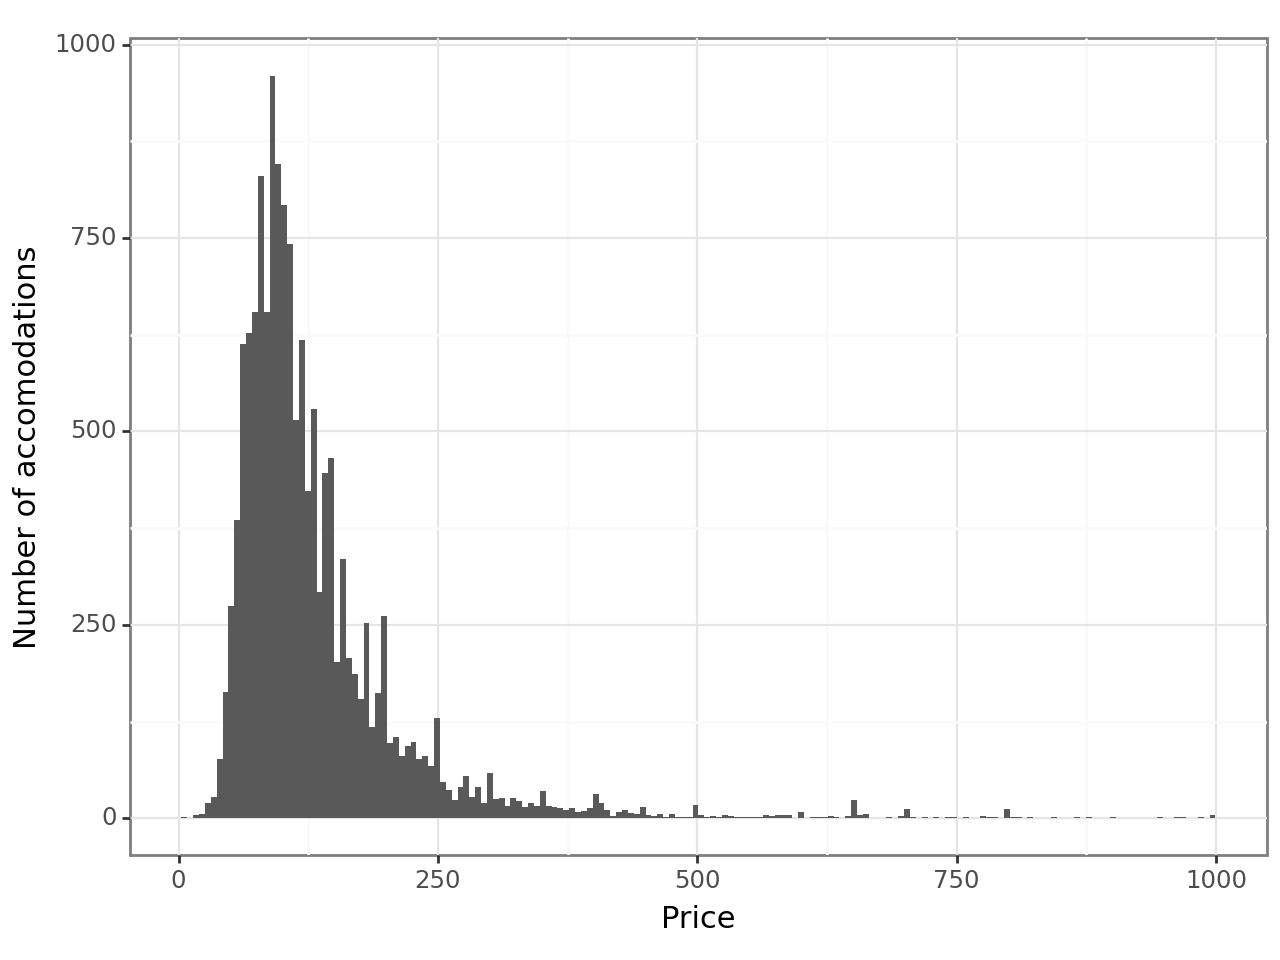

<Figure Size: (640 x 480)>

In [43]:
ggplot(data, aes("price")) + geom_histogram() + theme_bw() + xlab("Price") + ylab("Number of accomodations")

We seem to have most of the data with a price around 150 USD with a long right tail and very few extremely high prices. Price is to be kept on level so as to be able to predict absolute prices.

In [44]:
data.neighbourhood_cleansed.value_counts()

neighbourhood_cleansed
I Centro Storico              8208
II Parioli/Nomentano           941
VII San Giovanni/Cinecittà     923
XIII Aurelia                   882
XII Monte Verde                798
V Prenestino/Centocelle        621
X Ostia/Acilia                 444
VIII Appia Antica              356
XIV Monte Mario                291
XV Cassia/Flaminia             245
III Monte Sacro                233
XI Arvalia/Portuense           231
IV Tiburtina                   188
IX Eur                         174
VI Roma delle Torri             95
Name: count, dtype: int64

Most of the data is from Centro Storico, the other neighbourhoods are quite small in volume.

In [45]:
data.property_type.value_counts()

property_type
Entire rental unit           9149
Entire condo                 3665
Entire home                   531
Entire vacation home          490
Entire loft                   424
Entire serviced apartment     165
Tiny home                      63
Entire villa                   46
Entire guest suite             28
Entire townhouse               18
Entire place                   11
Entire guesthouse               9
Entire cottage                  6
Entire cabin                    4
Casa particular                 3
Holiday park                    3
Entire bed and breakfast        2
Dome                            2
Entire chalet                   2
Entire bungalow                 1
Farm stay                       1
Entire home/apt                 1
Room in aparthotel              1
Camper/RV                       1
Windmill                        1
Minsu                           1
Tower                           1
Cave                            1
Name: count, dtype: int64

Most of the accommodations are entire rental units or condos. We have a number of property types that have very few observations. This is something to be mindful of when interpreting the results.

In [46]:
data.accommodates.value_counts()

accommodates
4    5837
2    3293
6    2058
3    1832
5    1610
Name: count, dtype: int64

In [47]:
data.beds.value_counts()

beds
2.0    5970
1.0    3946
3.0    3052
4.0    1238
5.0     288
6.0     124
7.0      10
9.0       2
Name: count, dtype: int64

Very few accommodations have more than 5 beds.

## Modeling
For predictive modeling 3+1 models will be built. One with OLS by focusing on the accommodation related variables only and picking interactions and functional forms based on domain knowledge, one with random forest using all variables, and a third one with Gradient Boosting. Then we will revert back with the most important variables and create an OLS with them. To compare results, we will look at cross-validated RMSE scores.

### OLS

For the OLS I will simply use the accomodation related variables.

Checking scatterplots with price

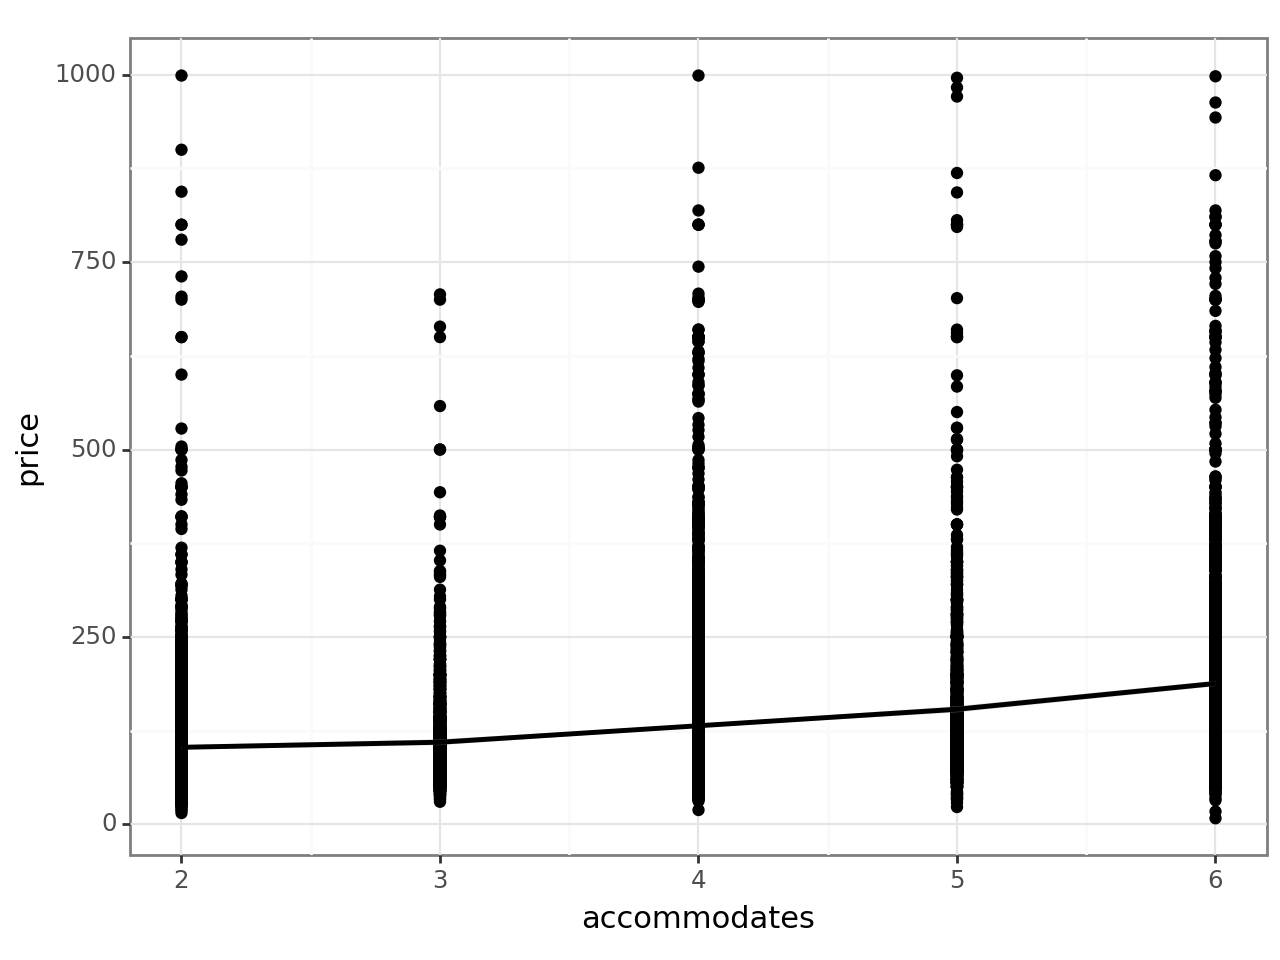

<Figure Size: (640 x 480)>

In [48]:
ggplot(data, aes("accommodates", "price")) + geom_point() + theme_bw() + geom_smooth(method = "loess")

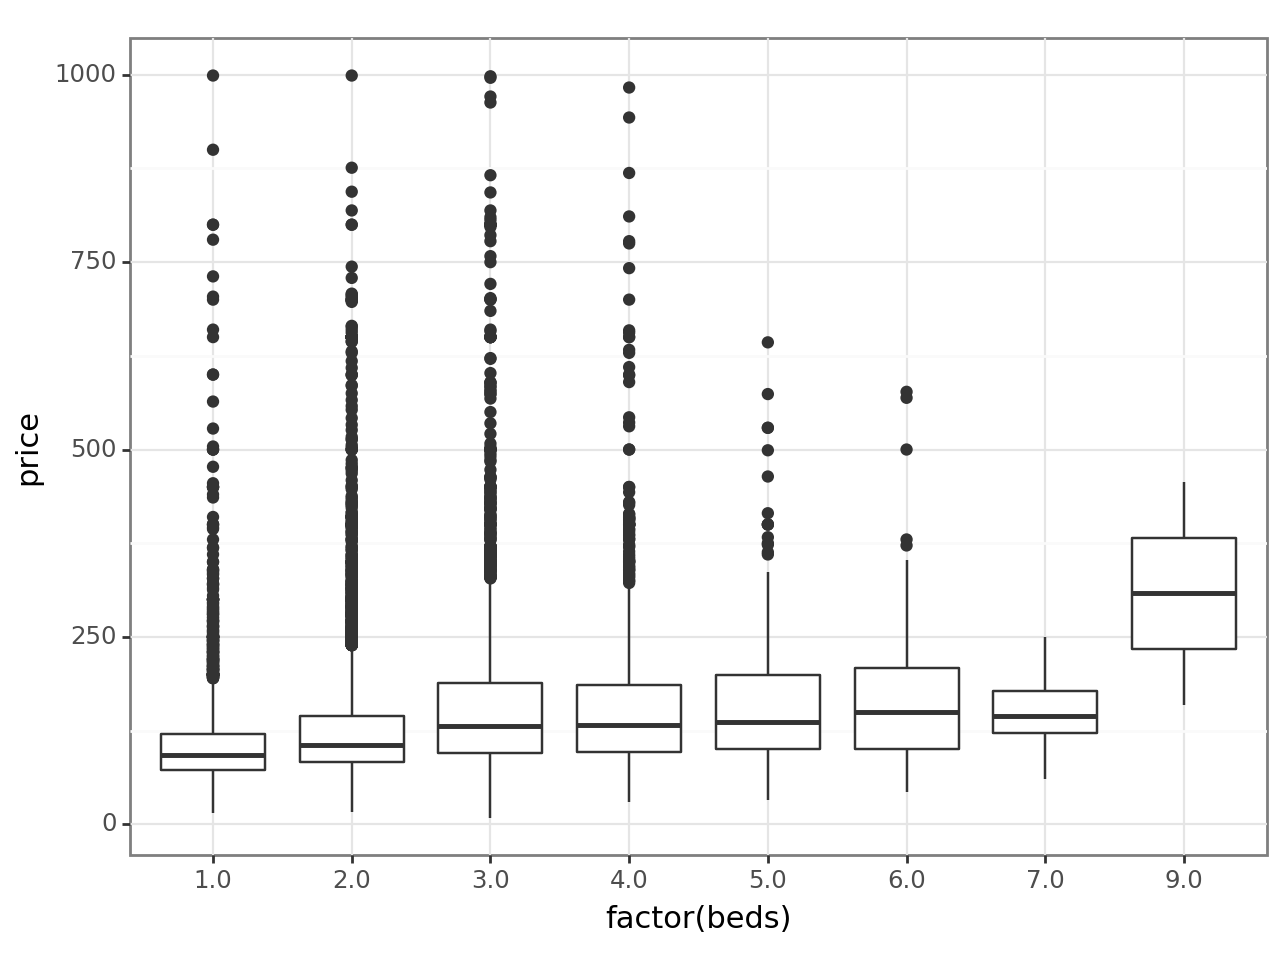

<Figure Size: (640 x 480)>

In [49]:
ggplot(data, aes("factor(beds)", "price")) + geom_boxplot() + theme_bw()

Average price increasing steadily with beds with a jump at 9 beds (although few variables here)

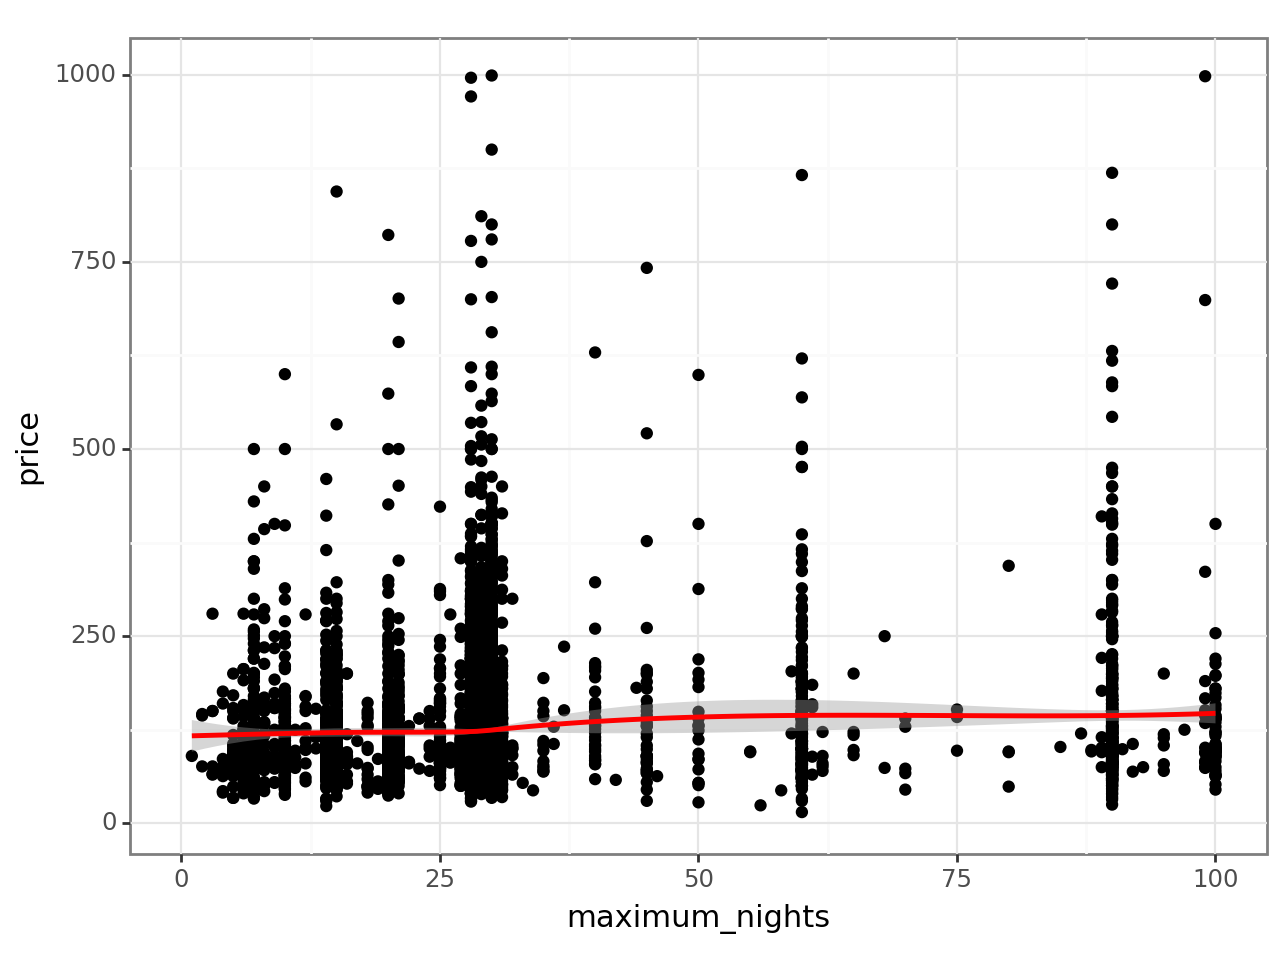

<Figure Size: (640 x 480)>

In [50]:
ggplot(data, aes("maximum_nights", "price")) + geom_point() + theme_bw() + geom_smooth(method = "loess", color = "red") + xlim(0, 100)

Price seems almost flat depending on max nights.

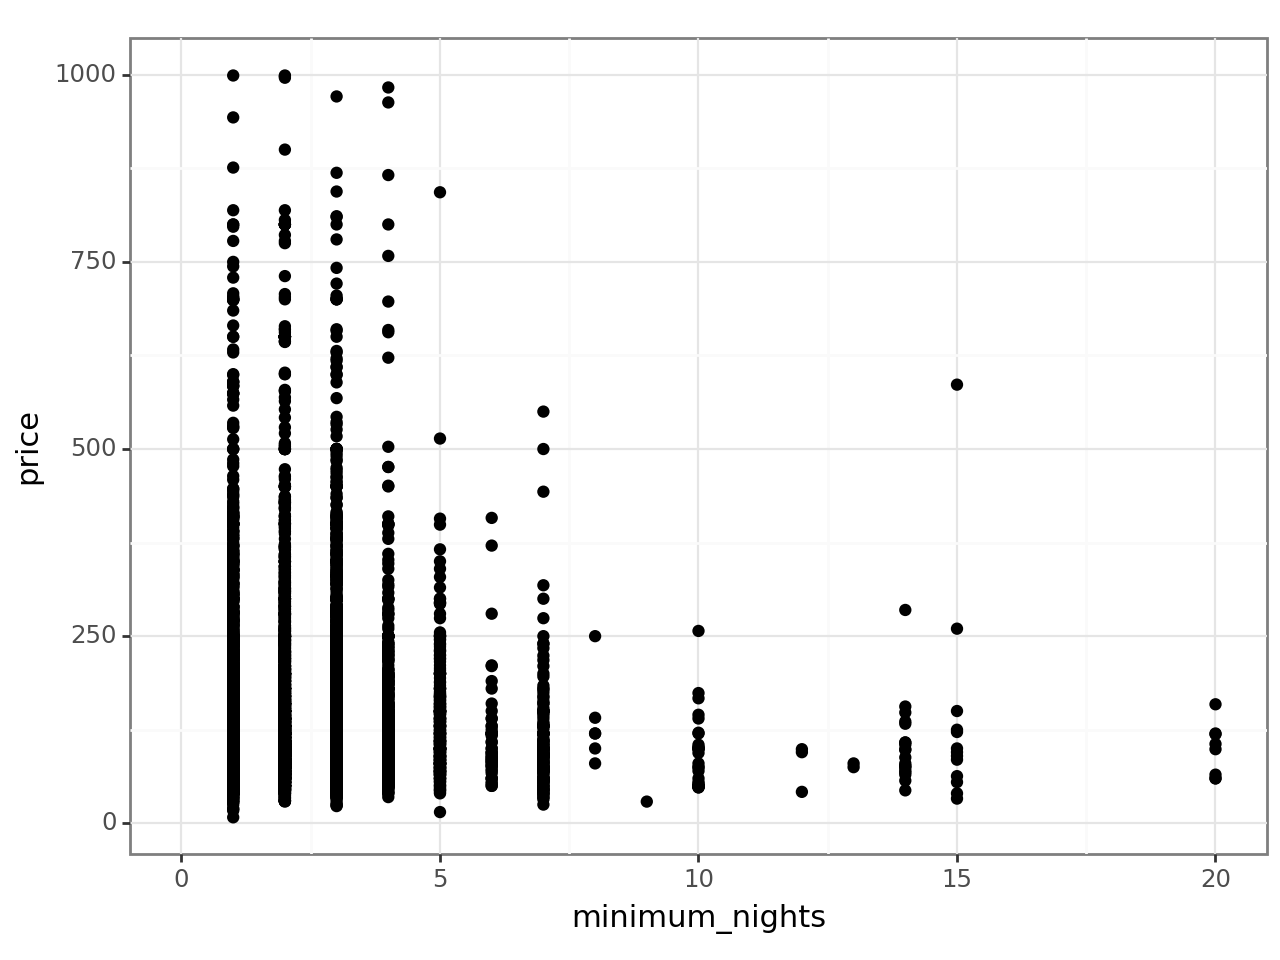

<Figure Size: (640 x 480)>

In [51]:
ggplot(data, aes("minimum_nights", "price")) + geom_point() + xlim(0,20) + theme_bw()

Possible non-linear relationship, therefore will include squared minimum_nights.

In [52]:
data["minimum_nights_2"] = data["minimum_nights"] ** 2

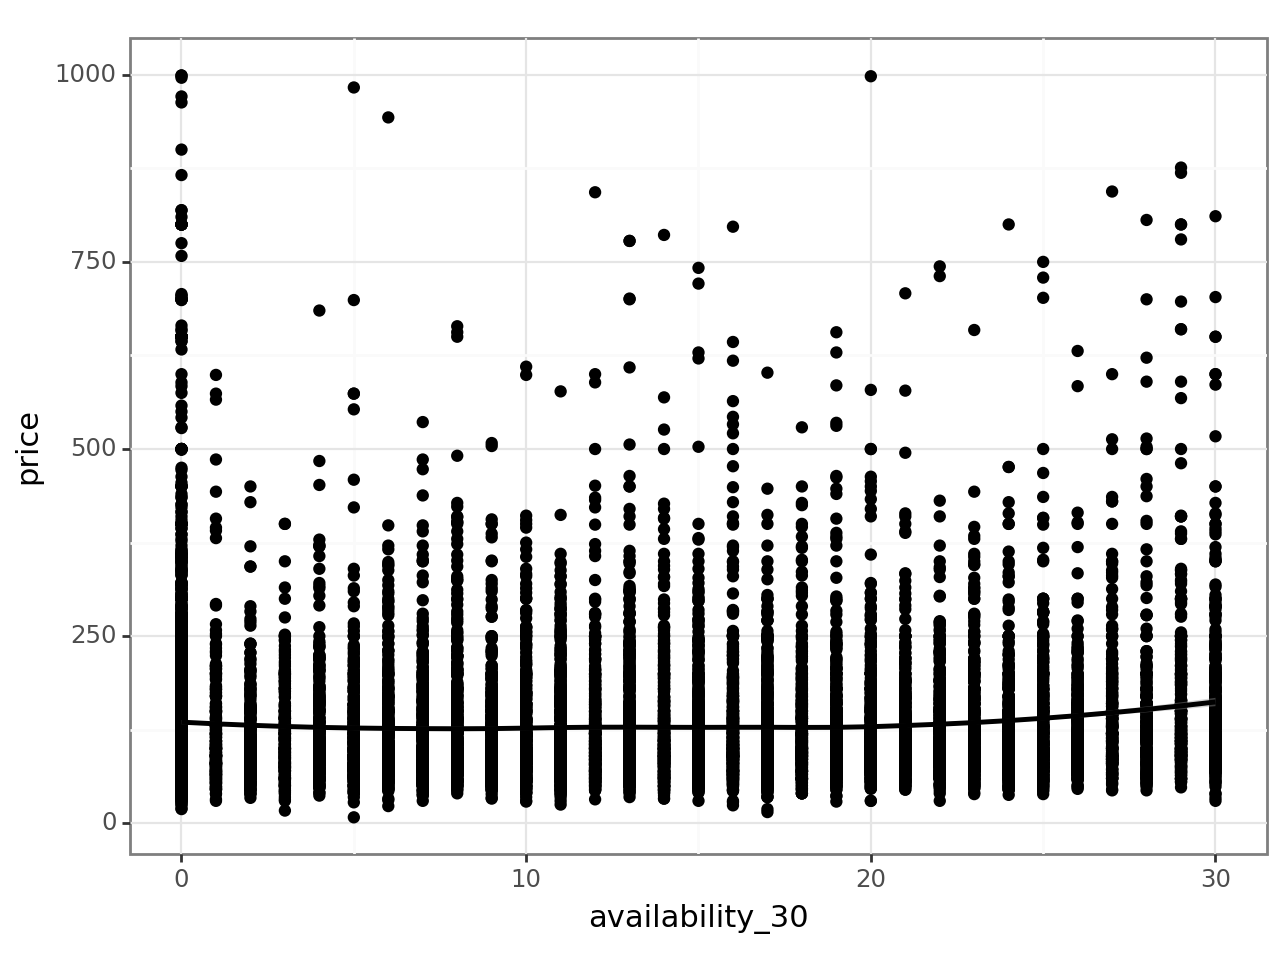

<Figure Size: (640 x 480)>

In [53]:
ggplot(data, aes("availability_30", "price")) + geom_point() + theme_bw() + geom_smooth(method = "loess")

Some non-linearity, but difficult to judge - will be kept as linear.

In [54]:
sns.regplot(
    data = data,
    x = 'bathrooms', y = 'price', 
    marker= '.',
    fit_reg= True, lowess= True);

Rather unusual pattern, will add bathrooms squared to account for non-linearity

In [55]:
data["bathrooms_2"] = data["bathrooms"] ** 2

In [56]:
from sklearn.linear_model import LinearRegression

In [57]:
ols_vars = accom_vars + ["bathrooms_2", "minimum_nights_2"]
ols_vars

['neighbourhood_cleansed',
 'property_type',
 'accommodates',
 'beds',
 'minimum_nights',
 'maximum_nights',
 'minimum_minimum_nights',
 'maximum_minimum_nights',
 'minimum_maximum_nights',
 'maximum_maximum_nights',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm',
 'has_availability',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'instant_bookable',
 'bathrooms',
 'bathrooms_2',
 'minimum_nights_2']

In [58]:
# splitting the data to train and holdout in 80-20% ratio

data_train, data_holdout = train_test_split(data, train_size=0.8, random_state=42)
data_train.shape, data_holdout.shape

((11704, 48), (2926, 48))

In [59]:
y, X = dmatrices("price ~ " + " + ".join(ols_vars), data_train)

ols_model = LinearRegression().fit(X,y)

#y_test, X_test = dmatrices("price ~ " + " + ".join(predictors_2), data_holdout)

y_hat = ols_model.predict(X)

ols_rmse = mean_squared_error(y,y_hat,squared=False)
ols_rmse

79.04778278510773

Not surprisingly, this model that only contains a rather arbitrary list of variables, and functional forms, performs poorly with a rather high RMSE.

In [60]:
ols_rmse/np.mean(data_train.price)

0.5960969487014963

### Random forest

In [61]:
all_vars = accom_vars + host_vars + review_vars
y, X = dmatrices("price ~ " + " + ".join(all_vars), data_train)

In [62]:
import math
print('The theoretical recommended number of variables: {:.2f}.'.format(math.sqrt(len(X.design_info.column_names))))

The theoretical recommended number of variables: 21.28.


In [63]:
rfr = RandomForestRegressor(random_state = 42)

In [64]:
# creating tune_grid with more and less max features than the theoretically optimal (8) and a few options for minimum sample size for stopping

tune_grid = {"max_features": [20, 23, 25, 28], "min_samples_leaf": [5, 10, 15]}

In [65]:
rf_random = GridSearchCV(
    rfr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

In [66]:
%%time
rf_model = rf_random.fit(X, y.ravel())

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END max_features=20, min_samples_leaf=5;, score=-76.858 total time=   1.5s
[CV 2/5] END max_features=20, min_samples_leaf=5;, score=-70.853 total time=   1.5s
[CV 3/5] END max_features=20, min_samples_leaf=5;, score=-74.734 total time=   1.5s
[CV 4/5] END max_features=20, min_samples_leaf=5;, score=-69.296 total time=   1.6s
[CV 5/5] END max_features=20, min_samples_leaf=5;, score=-83.731 total time=   1.5s
[CV 1/5] END max_features=20, min_samples_leaf=10;, score=-78.336 total time=   1.1s
[CV 2/5] END max_features=20, min_samples_leaf=10;, score=-72.148 total time=   1.2s
[CV 3/5] END max_features=20, min_samples_leaf=10;, score=-75.905 total time=   1.2s
[CV 4/5] END max_features=20, min_samples_leaf=10;, score=-70.394 total time=   1.2s
[CV 5/5] END max_features=20, min_samples_leaf=10;, score=-85.555 total time=   1.1s
[CV 1/5] END max_features=20, min_samples_leaf=15;, score=-79.259 total time=   1.0s
[CV 2/5] 

In [67]:
df_rf_model_cv_results = pd.DataFrame(rf_model.cv_results_)[[
    'param_max_features', 'param_min_samples_leaf', 'mean_test_score']]
df_rf_model_cv_results.columns = ['max features', 'min node size', 'RMSE']
df_rf_model_cv_results.pivot(
    index = 'max features', 
    columns = 'min node size', 
    values = 'RMSE').round(2)*-1

min node size,5,10,15
max features,,,
20,75.09,76.47,77.47
23,74.17,75.75,76.75
25,73.87,75.35,76.19
28,73.49,74.71,75.61


In [68]:
rf_model.best_score_

-73.48507545014772

#### checking feature importances

In [69]:
rf_model.best_estimator_

RandomForestRegressor(max_features=28, min_samples_leaf=5, random_state=42)

Best estimator has 28 features and 5 minimum observations in each node. 

In [70]:
pd.DataFrame(
    rf_model.best_estimator_.feature_importances_, 
    X.design_info.column_names)

,0
Intercept,0.000000
neighbourhood_cleansed[T.II Parioli/Nomentano],0.001669
neighbourhood_cleansed[T.III Monte Sacro],0.000347
neighbourhood_cleansed[T.IV Tiburtina],0.000250
neighbourhood_cleansed[T.IX Eur],0.000219
...,...
review_scores_checkin,0.019377
review_scores_communication,0.015489
review_scores_location,0.081011
review_scores_value,0.024670


In [71]:
df_var_imp = pd.DataFrame(
    rf_model.best_estimator_.feature_importances_, 
    X.design_info.column_names)\
    .reset_index()\
    .rename({"index": "variable", 0: "imp"}, axis=1)\
    .sort_values(by=["imp"], ascending=False)\
    .reset_index(drop = True)

df_var_imp['cumulative_imp'] = df_var_imp['imp'].cumsum()

In [76]:
df_var_imp.style.format({
    'imp': lambda x: f'{x:,.1%}',
    'cumulative_imp': lambda x: f'{x:,.1%}'})
df_var_imp.head()

,variable,imp,cumulative_imp
0,bathrooms,0.110868,0.110868
1,review_scores_location,0.081011,0.191879
2,accommodates,0.059571,0.251450
3,beds,0.042443,0.293893
4,reviews_per_month,0.040153,0.334046


In [73]:
# set cutoff for 2%

cutoff = 0.02

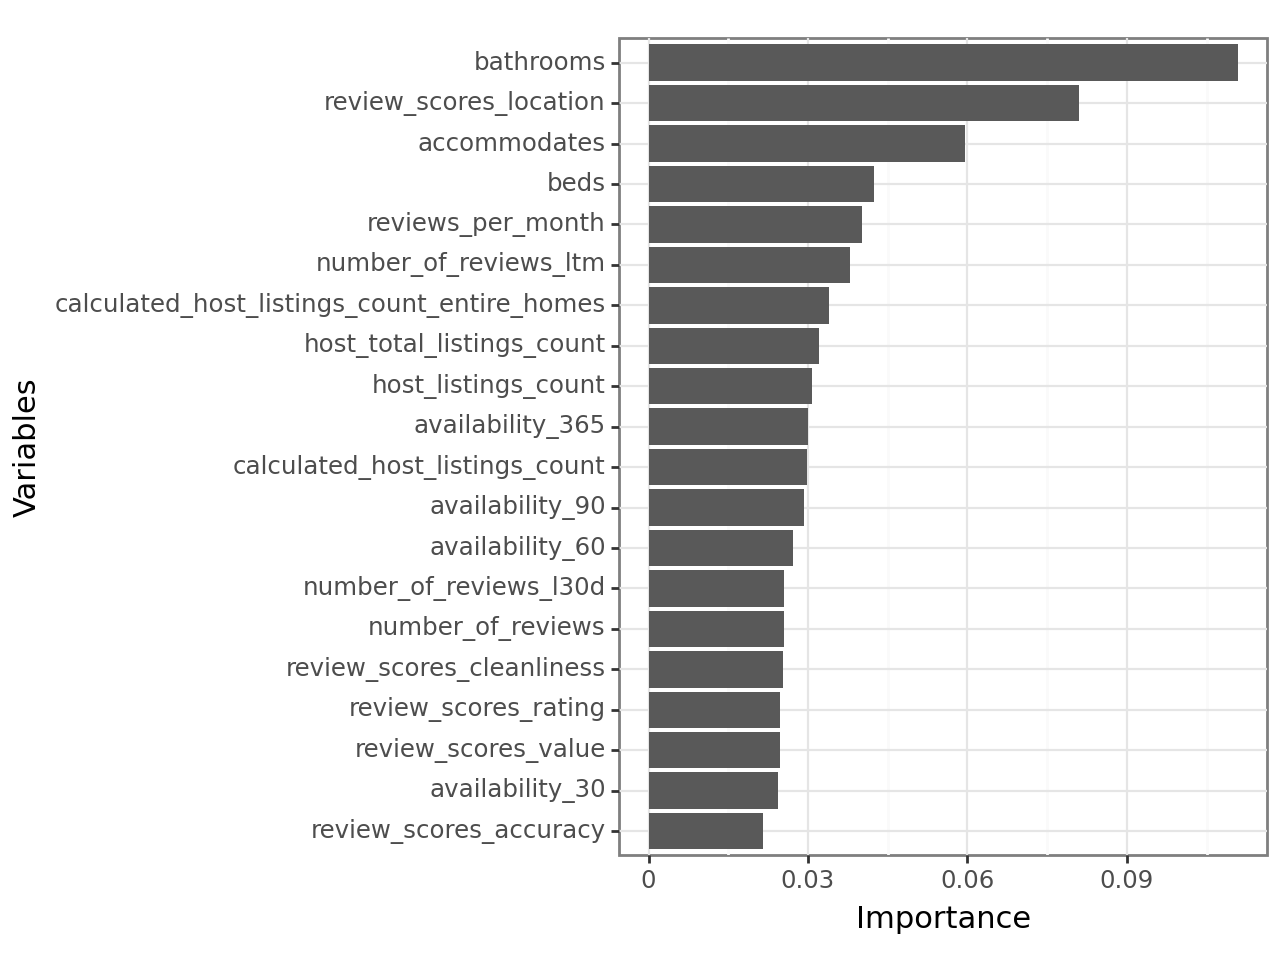

<Figure Size: (640 x 480)>

In [77]:
df_cutoff = df_var_imp[df_var_imp.imp > cutoff].sort_values(by = 'imp')
ggplot(df_cutoff, aes("reorder(variable, imp)", "imp")) + geom_col() + coord_flip() + theme_bw() + ylab("Importance") + xlab("Variables")

In the most important variables we find a mixture of accommodation and review related variables. There are only a handful of host related ones though. This somewhat confirms the initial intuition that the host is less important than the accommodation itself and the reviews of it.

Let's look at the grouped variable importances.

In [85]:
categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer([
    ("cat", categorical_encoder, cat_var),
    ("num", "passthrough", num_var)])

rf_pipeline = Pipeline(
    [("preprocess", preprocessing), 
     ("regressor", rf_model.best_estimator_)] # put best model to pipeline
)

In [86]:
%%time
rf_pipeline.fit(data_train[all_vars],data_train.price)

CPU times: total: 7 s
Wall time: 7.12 s


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['host_location',
                                                   'host_response_time',
                                                   'host_neighbourhood',
                                                   'host_verifications',
                                                   'neighbourhood_cleansed',
                                                   'property_type']),
                                                 ('num', 'passthrough',
                                                  ['host_response_rate',
                                                   'host_acceptance_rate',
                                                   'host_is_superhost',
                                                   'host_listings_count',
                                                   'host_total...
                                                   'availability_60',
                                                   'availability_90',
                                                   'availability_365',
                                                   'number_of_reviews',
                                                   'number_of_reviews_ltm',
                                                   'number_of_reviews_l30d',
                                                   'review_scores_rating',
                                                   'review_scores_accuracy',
                                                   'review_scores_cleanliness',
                                                   'review_scores_checkin',
                                                   'review_scores_communication', ...])])),
                ('regressor',
                 RandomForestRegressor(max_features=28, min_samples_leaf=5,
                                       random_state=42))])

In [97]:
%%time
result = permutation_importance(
    rf_pipeline,
    data_train[all_vars],
    data_train.price,
    n_repeats=10,
    random_state=45,
)

CPU times: total: 1min 35s
Wall time: 1min 36s


In [104]:
pd.DataFrame(
        result.importances_mean,
        data_train[all_vars].columns).head()

,0
neighbourhood_cleansed,0.084680
property_type,0.010656
accommodates,0.059783
beds,0.048730
minimum_nights,0.009820


In [101]:
df_grouped_var_imp = pd.DataFrame(
        result.importances_mean,
        data_train[all_vars].columns)\
    .sort_values(by = 0, ascending = False)\
    .reset_index()\
    .rename({'index': 'variable', 0: 'imp'}, axis = 1)
df_grouped_var_imp['cumulative_imp'] = df_grouped_var_imp.imp.cumsum()

In [107]:
df_grouped_var_imp.style.format({
    'imp': lambda x: f'{x:,.1%}',
    'cumulative_imp': lambda x: f'{x:,.1%}'})
df_grouped_var_imp.head()

,variable,imp,cumulative_imp
0,bathrooms,0.092306,0.092306
1,neighbourhood_cleansed,0.084680,0.176986
2,review_scores_location,0.075488,0.252474
3,accommodates,0.059783,0.312257
4,reviews_per_month,0.049203,0.361460


Let's visualise the ones that have a higher than 2% importance.

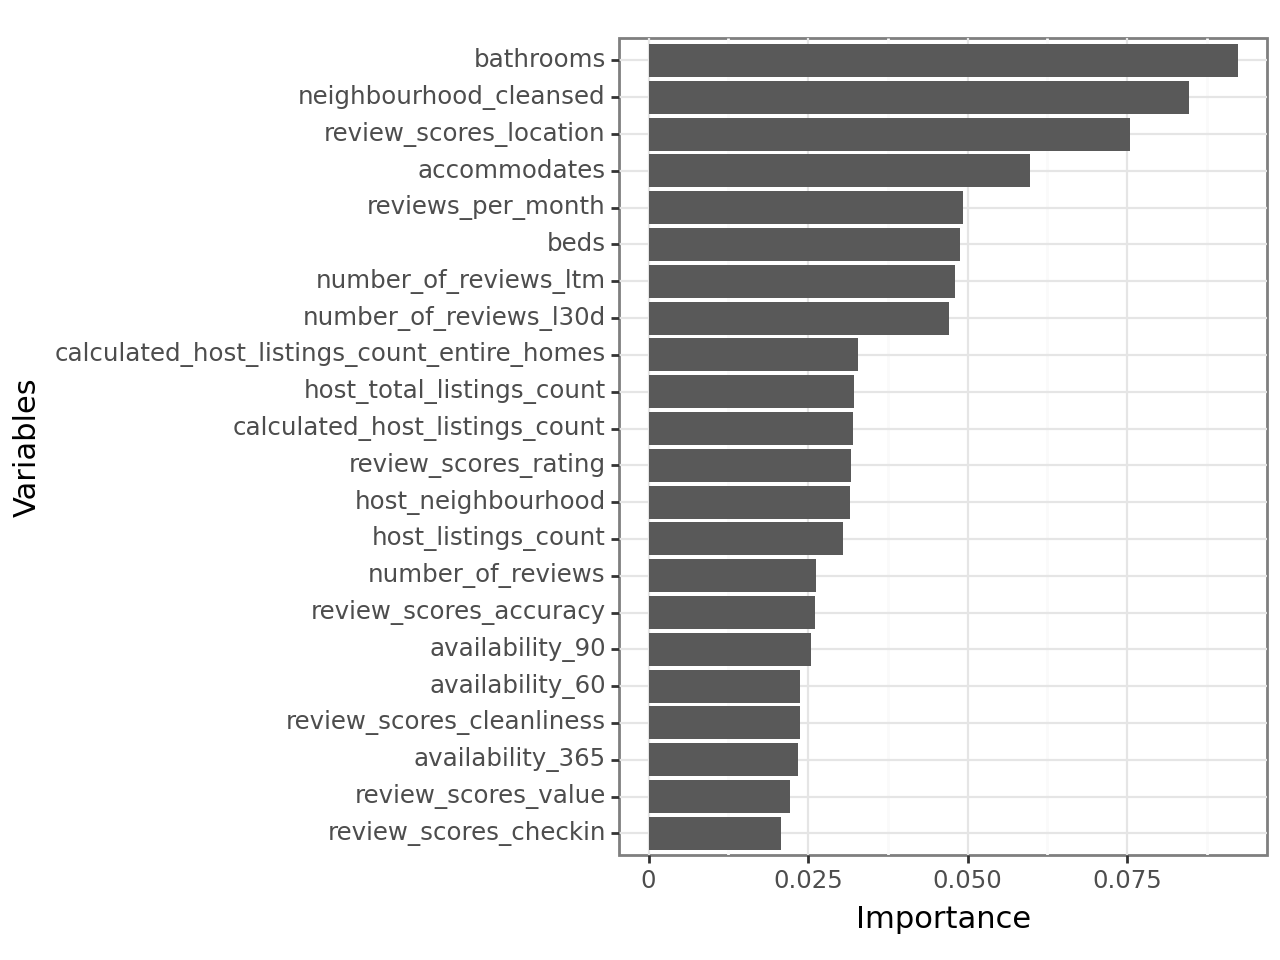

<Figure Size: (640 x 480)>

In [103]:
cutoff_grouped = 0.02
df_cutoff_gr = df_grouped_var_imp[df_grouped_var_imp.imp > cutoff_grouped].sort_values(by = 'imp')
ggplot(df_cutoff_gr, aes("reorder(variable, imp)", "imp")) + geom_col() + coord_flip() + theme_bw() + ylab("Importance") + xlab("Variables")

2 feature importances have appeared newly: neighbourhood and host neighbourhood. This suggest that although one specific neighbourhood does not have a high importance, in general, the location/neighbourhood of the AirBnB is important. This is also confirmed by the high importance of the review scores on location.

#### Partial dependence plots of the top 5 most important variables

In [110]:
bathrooms_pdp = partial_dependence(
    rf_pipeline, data_holdout[all_vars], ["bathrooms"], kind="average"
)

In [119]:
pdp_bath = pd.DataFrame(
    {'Number of bathrooms': bathrooms_pdp['values'][0], 
     'Average price': bathrooms_pdp['average'][0]}
    )

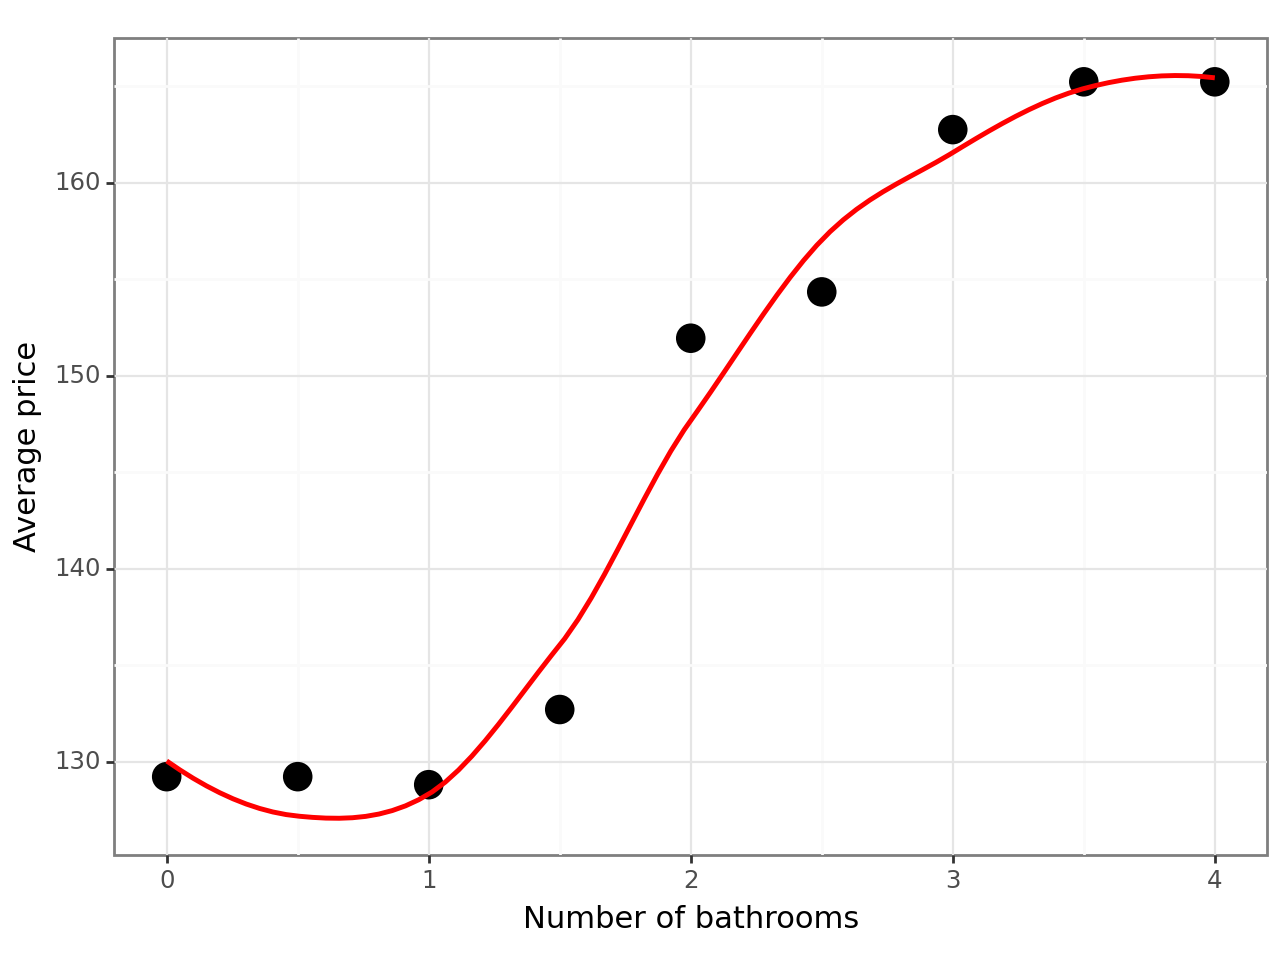

<Figure Size: (640 x 480)>

In [124]:
ggplot(pdp_bath, aes("Number of bathrooms", "Average price")) + geom_point(size = 5) + theme_bw() + geom_smooth(method="loess", se = False, color = "red")

The number of bathrooms does not make a huge difference below 2 bathrooms. Then there's a major jump and the relationship then flattens out.

In [125]:
neighbourhood_pdp = partial_dependence(
    rf_pipeline, data_holdout[all_vars], ["neighbourhood_cleansed"], kind="average"
)

In [126]:
pdp_neighb = pd.DataFrame(
    {'Neighbourhoods': neighbourhood_pdp['values'][0], 
     'Average price': neighbourhood_pdp['average'][0]}
    )

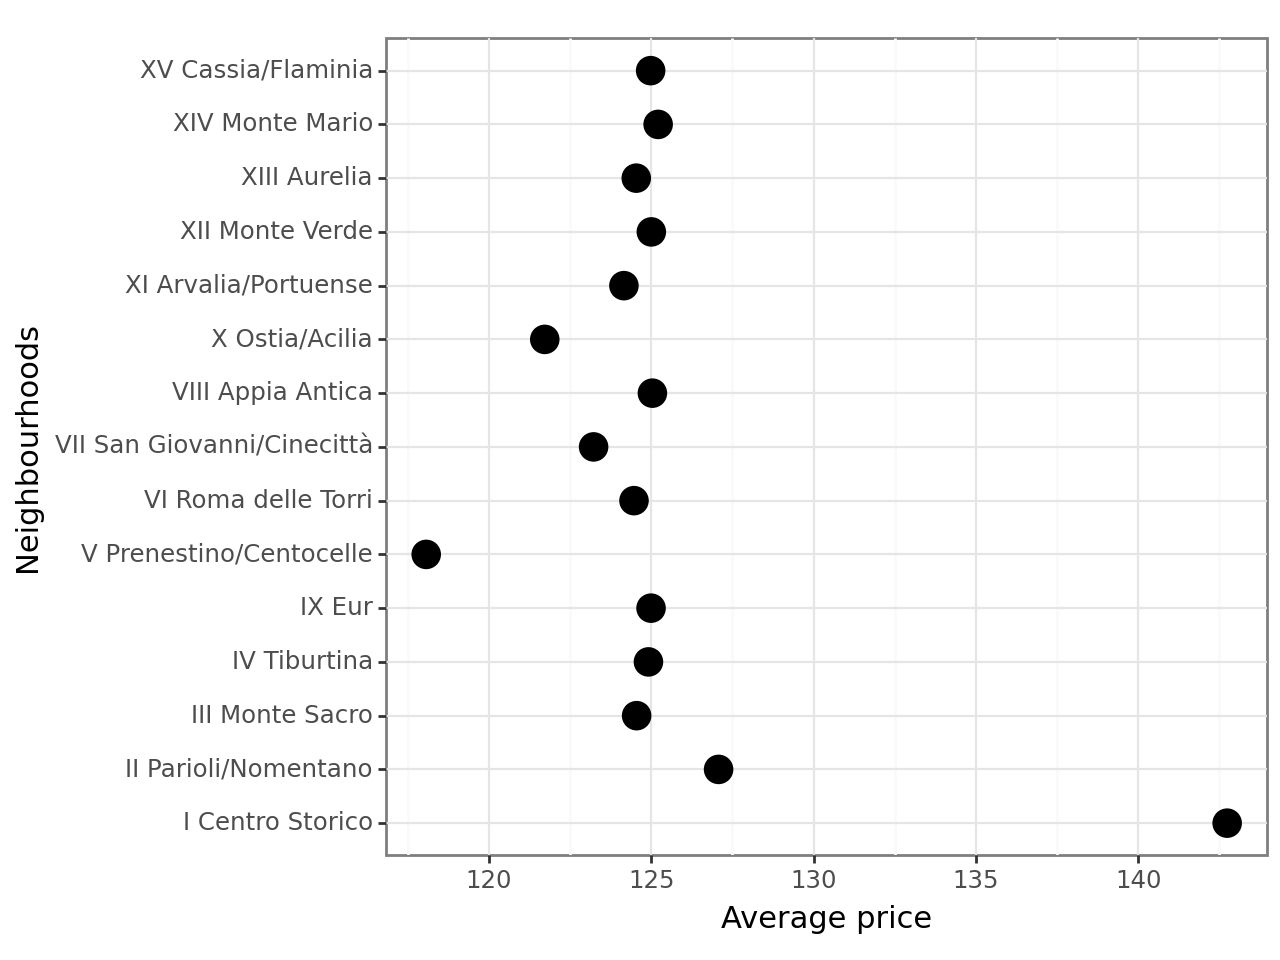

<Figure Size: (640 x 480)>

In [129]:
ggplot(pdp_neighb, aes("Neighbourhoods", "Average price")) + geom_point(size = 5) + theme_bw() + coord_flip()

It is clearly visible that the Centro Storico has the highest prices, while Prenestino/Centocelle has the lowest, while the others are more or less similar. Interestingly the 2 extremes did not show up in the feature importance, but once groped together, location became important.

In [130]:
rev_location = partial_dependence(
    rf_pipeline, data_holdout[all_vars], ["review_scores_location"], kind="average"
)

In [131]:
pdp_rev_loc = pd.DataFrame(
    {'Review scores - location': rev_location['values'][0], 
     'Average price': rev_location['average'][0]}
    )

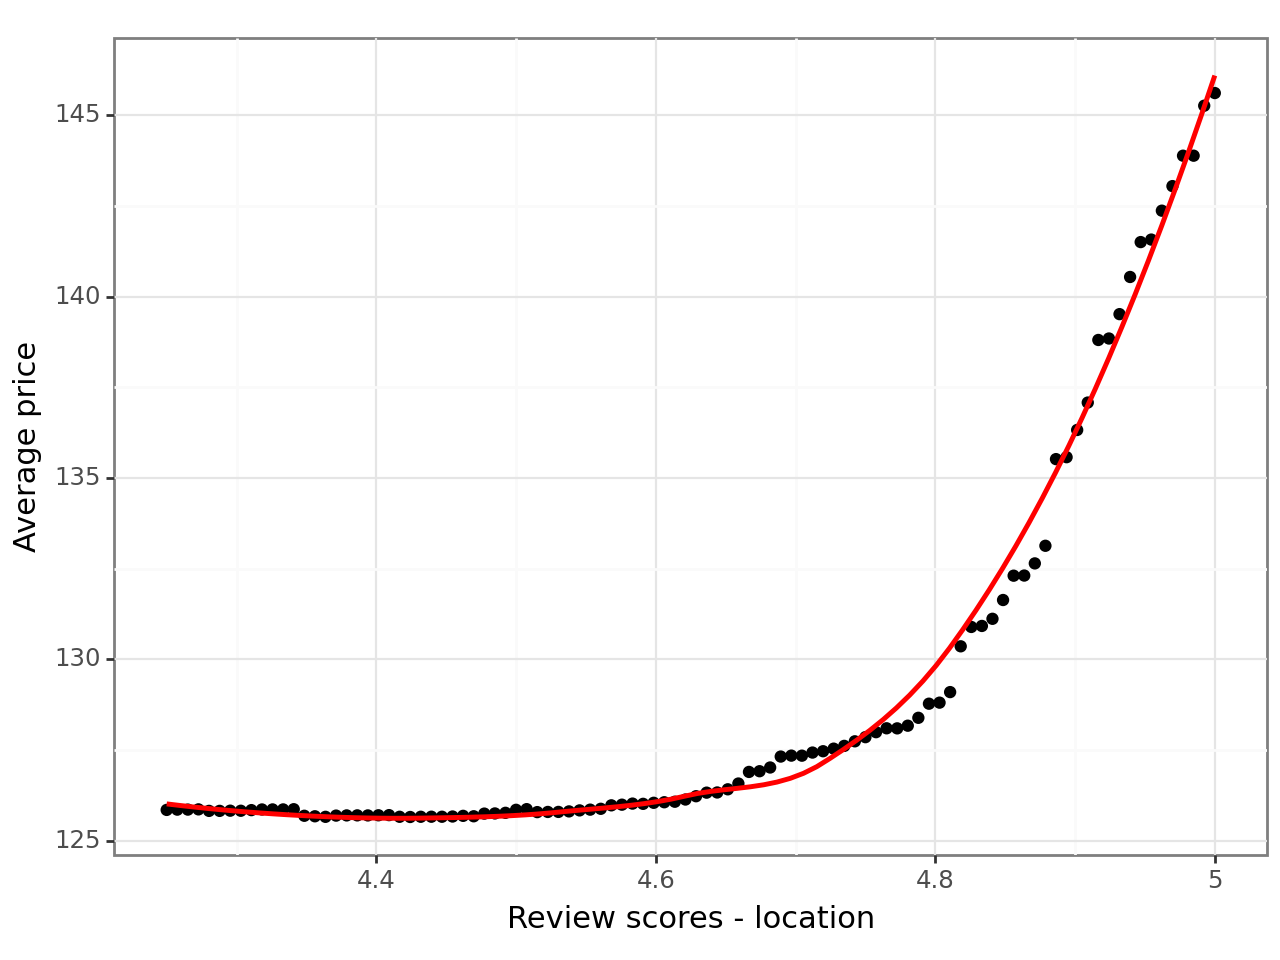

<Figure Size: (640 x 480)>

In [133]:
ggplot(pdp_rev_loc, aes("Review scores - location", "Average price")) + geom_point() + theme_bw() + geom_smooth(method="loess", se = False, color = "red")

There's an exponential relationship between review scores on location. Average prices grow massively above around 4.8 score on location.

In [134]:
accomodates_pdp = partial_dependence(
    rf_pipeline, data_train[all_vars], ["accommodates"], kind="average"
)

In [136]:
accomm_pdp = pd.DataFrame(
    {'Number of accomodates': accomodates_pdp['values'][0], 
     'Average price': accomodates_pdp['average'][0]}
    )

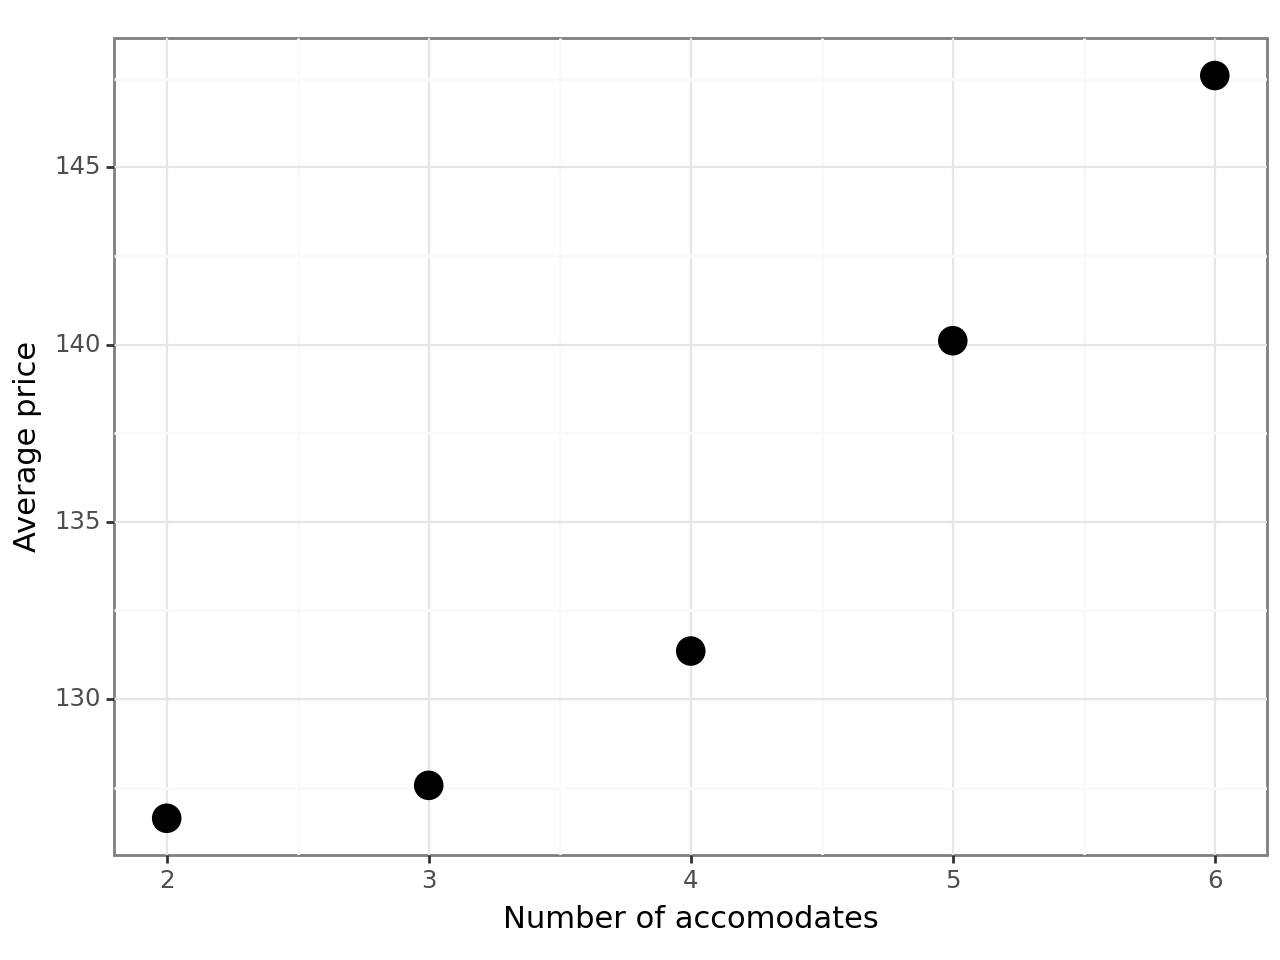

<Figure Size: (640 x 480)>

In [139]:
ggplot(accomm_pdp, aes("Number of accomodates", "Average price")) + geom_point(size = 5) + theme_bw()

Given that the analysis was focusing on AirBnBs that can accommodate between 2-6 people, we have relatively few categories. Although there seems to be a non-linear relationship here as well.

In [140]:
revies_monthly = partial_dependence(
    rf_pipeline, data_holdout[all_vars], ["reviews_per_month"], kind="average"
)

In [141]:
reviews_pdp = pd.DataFrame(
    {'Number of monthly reviews': revies_monthly['values'][0], 
     'Average price': revies_monthly['average'][0]}
    )

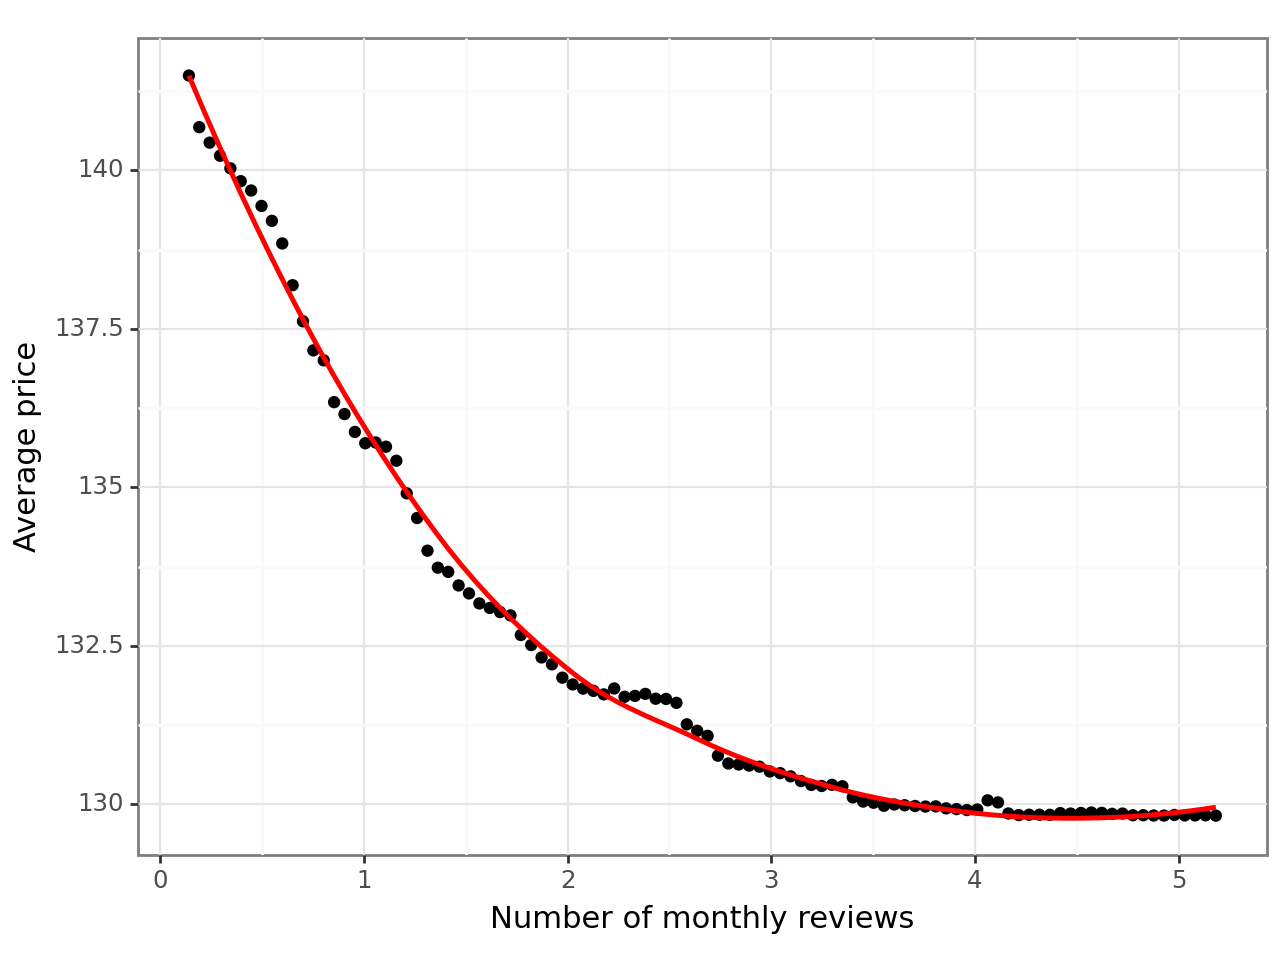

<Figure Size: (640 x 480)>

In [142]:
ggplot(reviews_pdp, aes("Number of monthly reviews", "Average price")) + geom_point() + theme_bw() + geom_smooth(method="loess", se = False, color = "red")

Interestingly, monthly review counts have a non-linear and negative relationship with price.